# Extended Large Language Model (LLM) with Transformer Blocks

This notebook builds on the mini LLM example by incorporating self-attention and transformer blocks to simulate a more realistic architecture.
We implement a simplified version of GPT-style decoder blocks.

# Step 1: Import Required Libraries

In [128]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Step 2: Load and Preprocess Text

In [158]:
text = open("RomeoJuliet.txt", encoding='utf-8').read()
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# Step 3: Hyperparameters and Batch Loader

In [161]:
block_size = 128
batch_size = 64
max_iters = 2000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

In [163]:
# Step 4: Transformer Block with Self-Attention

In [165]:
class Head(nn.Module):
    def __init__(self, head_size, n_embed, block_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.dropout = nn.Dropout(0.2)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        return wei @ v

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, n_embed, block_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, n_embed, block_size) for _ in range(num_heads)])
        self.proj = nn.Linear(num_heads * head_size, n_embed)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class TransformerBlock(nn.Module):
    def __init__(self, n_embed, num_heads):
        super().__init__()
        head_size = n_embed // num_heads
        self.sa = MultiHeadAttention(num_heads, head_size, n_embed, block_size)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ffwd = nn.Sequential(
            nn.Linear(n_embed, 4 * n_embed),
            nn.ReLU(),
            nn.Linear(4 * n_embed, n_embed),
            nn.Dropout(0.2),
        )
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class TransformerLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, n_embed)
        self.pos_embed = nn.Embedding(block_size, n_embed)
        self.blocks = nn.Sequential(*[TransformerBlock(n_embed, num_heads=8) for _ in range(6)])
        self.ln_f = nn.LayerNorm(n_embed)
        self.dropout = nn.Dropout(0.2)
        self.head = nn.Linear(n_embed, vocab_size)

    def forward(self, idx):
        B, T = idx.shape
        tok_emb = self.token_embed(idx)
        pos_emb = self.pos_embed(torch.arange(T, device=idx.device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        x = self.dropout(x)
        logits = self.head(x)
        return logits

n_embed = 128
model = TransformerLanguageModel().to(device)

In [167]:
# Step 5: Train the Model

  0%|                                                                                 | 1/2000 [00:00<24:01,  1.39it/s]

Step 0: loss = 4.7147


  5%|███▉                                                                           | 101/2000 [01:08<21:05,  1.50it/s]

Step 100: loss = 3.0819


 10%|███████▉                                                                       | 201/2000 [02:15<20:17,  1.48it/s]

Step 200: loss = 2.8946


 15%|███████████▉                                                                   | 301/2000 [03:23<19:26,  1.46it/s]

Step 300: loss = 2.8488


 20%|███████████████▊                                                               | 401/2000 [04:31<18:16,  1.46it/s]

Step 400: loss = 2.7446


 25%|███████████████████▊                                                           | 501/2000 [05:39<17:01,  1.47it/s]

Step 500: loss = 2.6635


 30%|███████████████████████▋                                                       | 601/2000 [06:47<15:57,  1.46it/s]

Step 600: loss = 2.5450


 35%|███████████████████████████▋                                                   | 701/2000 [07:55<14:39,  1.48it/s]

Step 700: loss = 2.5207


 40%|███████████████████████████████▋                                               | 801/2000 [09:03<13:25,  1.49it/s]

Step 800: loss = 2.4393


 45%|███████████████████████████████████▌                                           | 901/2000 [10:11<12:27,  1.47it/s]

Step 900: loss = 2.4131


 50%|███████████████████████████████████████                                       | 1001/2000 [11:19<11:10,  1.49it/s]

Step 1000: loss = 2.3348


 55%|██████████████████████████████████████████▉                                   | 1101/2000 [12:27<10:11,  1.47it/s]

Step 1100: loss = 2.2912


 60%|██████████████████████████████████████████████▊                               | 1201/2000 [13:35<09:01,  1.48it/s]

Step 1200: loss = 2.3030


 65%|██████████████████████████████████████████████████▋                           | 1301/2000 [14:42<07:53,  1.48it/s]

Step 1300: loss = 2.2306


 70%|██████████████████████████████████████████████████████▋                       | 1401/2000 [15:50<06:47,  1.47it/s]

Step 1400: loss = 2.2230


 75%|██████████████████████████████████████████████████████████▌                   | 1501/2000 [16:58<05:39,  1.47it/s]

Step 1500: loss = 2.2236


 80%|██████████████████████████████████████████████████████████████▍               | 1601/2000 [18:06<04:32,  1.46it/s]

Step 1600: loss = 2.2092


 85%|██████████████████████████████████████████████████████████████████▎           | 1701/2000 [19:14<03:22,  1.48it/s]

Step 1700: loss = 2.1799


 90%|██████████████████████████████████████████████████████████████████████▏       | 1801/2000 [20:21<02:15,  1.47it/s]

Step 1800: loss = 2.2011


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1901/2000 [21:29<01:06,  1.48it/s]

Step 1900: loss = 2.1537


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [22:36<00:00,  1.47it/s]


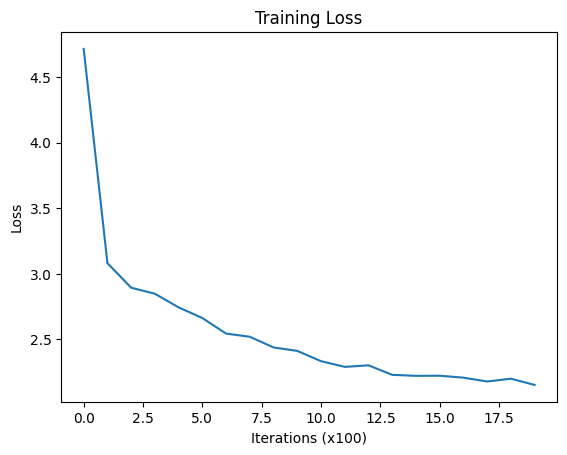

In [169]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    total_steps=max_iters,
    pct_start=0.1,
    anneal_strategy='linear'
)

losses = []

for step in tqdm(range(max_iters)):
    xb, yb = get_batch('train')
    logits = model(xb)
    B, T, C = logits.shape
    loss = F.cross_entropy(logits.view(B * T, C), yb.view(B * T), label_smoothing=0.1)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    
    if step % eval_interval == 0:
        print(f"Step {step}: loss = {loss.item():.4f}")
        losses.append(loss.item())

plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Iterations (x100)")
plt.ylabel("Loss")
plt.show()

In [171]:
# Step 6: Generate Text

In [182]:
def generate(model, start_text, max_new_tokens=200, temperature=1.0, top_k=50, top_p=0.95):
    model.eval()
    idx = torch.tensor([encode(start_text)], dtype=torch.long).to(device)

    for _ in range(max_new_tokens):
        idx_crop = idx[:, -block_size:]
        logits = model(idx_crop)
        logits = logits[:, -1, :] / temperature
        probs = F.softmax(logits, dim=-1)

        # Top-k filtering
        if top_k is not None:
            top_k = min(top_k, probs.size(-1))
            values, _ = torch.topk(probs, top_k)
            probs[probs < values[:, [-1]]] = 0

        # Top-p (nucleus) filtering
        if top_p is not None:
            sorted_probs, sorted_indices = torch.sort(probs, descending=True)
            cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
            cutoff = cumulative_probs > top_p
            if torch.any(cutoff):
                idx_cutoff = cutoff[0].nonzero(as_tuple=True)[0][0]
                probs[0, sorted_indices[0, idx_cutoff + 1:]] = 0

        probs = probs / probs.sum()  # re-normalize
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

print(generate(model, "ROMEO:\n", max_new_tokens=200, temperature=0.7, top_k=40, top_p=0.9))

ROMEO:
And you fair with me to made thee say him.

PRINCE.
And be for sice for not the man moning the will.

MERCUTIO.
Hold look with that the barth is but sirring all broove.

NURSE.
O marre as be the pare 
